<a href="https://colab.research.google.com/github/rodjfg/los-fabulosos-pixelotls/blob/master/Left_Rigth_model_Flor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Left / Right model

In [101]:
!pip install --quiet git+https://github.com/rodjfg/los-fabulosos-pixelotls

In [102]:
from los_fabulosos_pixelotls.tools import load_raw_data, select_by_areas, select_by_contrast, select_trials, calculate_mean_firing_rate, select_by_response
import numpy as np
from matplotlib import rcParams 
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression

rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [103]:
# get data
alldat = load_raw_data()

In [255]:
selected_regions = ['VISp']
gaussfilter = True
gauss_sigma = 1

samples = np.empty((0,250))
norm_samples = np.empty((0,250))
y = np.empty((0,))


for dat in alldat:
  dt = dat['bin_size']

  neurons_indices_in_area = select_by_areas(dat, selected_regions = selected_regions)
  #Mean responses hole brain
  mean_spikes_per_brain = np.mean(dat['spks'][neurons_indices_in_area])/dt
  std_spikes_per_brain = np.std(dat['spks'][neurons_indices_in_area])/dt

  if len(neurons_indices_in_area) > 0:

    right_response_trials = select_by_response(dat, response_type = 'to_left') # trials in which mouse should move to the left (higher contrast on right side)
    left_response_trials = select_by_response(dat, response_type = 'to_right') # trials in which mouse should move to the right (higher contrast on left side)

    # average firing rate across neuron population (e.g. VISp) for each trial in which mouse moved to the left
    right_firing_rates = calculate_mean_firing_rate(dat['spks'][neurons_indices_in_area][:,right_response_trials], dt, ['population'], gaussfilter = gaussfilter, gauss_sigma = gauss_sigma)
    norm_right_firing_rates = (right_firing_rates - mean_spikes_per_brain)/std_spikes_per_brain
    
    # average firing rate across neuron population (e.g. VISp) for each trial in which mouse moved to the right
    left_firing_rates = calculate_mean_firing_rate(dat['spks'][neurons_indices_in_area][:,left_response_trials], dt, ['population'], gaussfilter = gaussfilter, gauss_sigma = gauss_sigma)
    norm_left_firing_rates = (left_firing_rates - mean_spikes_per_brain)/std_spikes_per_brain

    # find minimum number of samples that can be extracted from both conditions
    n_min = min(right_firing_rates.shape[0],left_firing_rates.shape[0])
    samples = np.concatenate((samples,right_firing_rates[:n_min,...]),axis=0)
    samples = np.concatenate((samples,left_firing_rates[:n_min,...]),axis=0)

    #Normalised samples
    norm_samples = np.concatenate((norm_samples,norm_right_firing_rates[:n_min,...]),axis=0)
    norm_samples = np.concatenate((norm_samples,norm_left_firing_rates[:n_min,...]),axis=0)

    # 1: mouse moved to the left, 0: mouse moved to the right
    y = np.concatenate( (y, np.ones(n_min)) )
    y = np.concatenate( (y, np.zeros(n_min)) )

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [256]:
y.shape, samples.shape

((1962,), (1962, 250))

In [257]:
y.shape, norm_samples.shape

((1962,), (1962, 250))

In [236]:
np.allclose(samples,norm_samples)

False

TRAIN AND TEST SPLIT

In [258]:
samples_train, samples_test, y_train, y_test = train_test_split(samples, y, test_size=0.23, random_state=42)

In [259]:
samples_train_norm, samples_test_norm, y_train, y_test = train_test_split(norm_samples, y, test_size=0.23, random_state=42)

In [260]:
# C: float, default=1.0, Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.

# clf = LogisticRegressionCV(Cs=5, cv=4, penalty='l2', tol=0.0001, max_iter=5000, random_state=42).fit(samples_train, y_train)
clf = LogisticRegression(penalty='l2', C =0.1, solver='saga', tol=0.0001, max_iter=8000, random_state=42).fit(samples_train, y_train)
clf_norm = LogisticRegression(penalty='l2', C =0.1, solver='saga', tol=0.0001, max_iter=8000, random_state=42).fit(samples_train_norm, y_train)

In [261]:
print('***Train***')
print('Score:', clf.score(samples_train,y_train))
print('Norm_Score:',clf_norm.score(samples_train_norm,y_train))

print('***Test***')
print('Score:',clf.score(samples_test,y_test))
print('Norm_Score:',clf_norm.score(samples_test_norm,y_test))

***Train***
Score: 0.6788079470198676
Norm_Score: 0.6437086092715232
***Test***
Score: 0.5685840707964602
Norm_Score: 0.5995575221238938


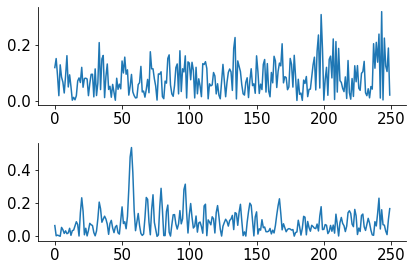

In [262]:
plt.subplot(211)
plt.plot(np.abs(clf.coef_[0,:]))
plt.subplot(212)
plt.plot(np.abs(clf_norm.coef_[0,:]))
plt.show()

In [263]:
def clasificator_analisis(model, X, y):
  '''Compute accuracy with CV, confusion matrix, precision-recall scores and plot ROC and precision-recall curves.
   Args: 
     model = model object trained from sklearn
         X = input features in train or test
         y = target in train or test
   Return:
    Print of all the scores computed and save accuracy, cm, precision, recall
'''
  
  from sklearn.model_selection import cross_val_predict, cross_val_score
  from sklearn.metrics import confusion_matrix, precision_score, recall_score, plot_precision_recall_curve, plot_roc_curve

  accu = cross_val_score(model, X, y, cv=5, scoring="accuracy").mean()
  print(f'{model} \nAccuracy:{accu}\n')
  pred = cross_val_predict(model, X, y, cv=5)
  cm = confusion_matrix(y,pred)
  print(f'Confusion Matrix: \n {cm}\n')
  precision = precision_score(y,pred)
  print('Precision:',precision)
  recall = recall_score(y, pred)
  print('Recall:', recall)
  plot_precision_recall_curve(model, X, y)
  plt.show()

  plot_roc_curve(model, X, y)
  plt.plot([0, 1], [0, 1], color='0.5', ls=':')
  plt.show()
  
  #return accu, cm, precision, recall

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=8000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False) 
Accuracy:0.5552380952380952

Confusion Matrix: 
 [[151  93]
 [108 100]]

Precision: 0.5181347150259067
Recall: 0.4807692307692308


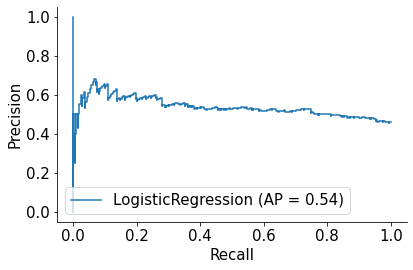

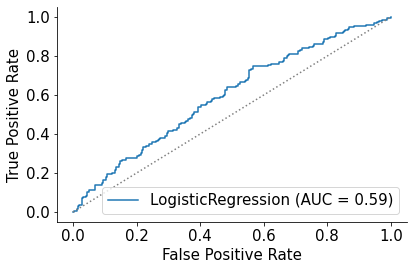

In [264]:
clasificator_analisis(clf,samples_test,y_test )

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=8000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False) 
Accuracy:0.5684981684981685

Confusion Matrix: 
 [[199  45]
 [150  58]]

Precision: 0.5631067961165048
Recall: 0.27884615384615385


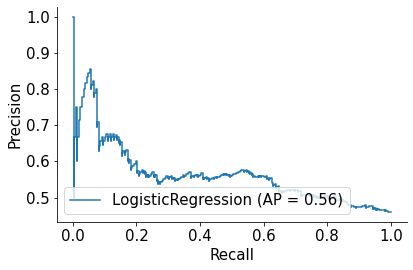

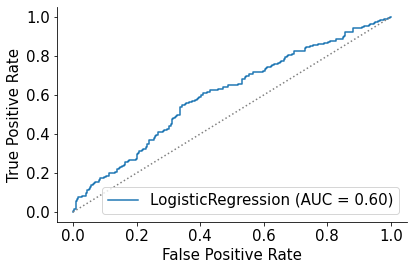

In [266]:
clasificator_analisis(clf_norm,samples_test_norm,y_test)

In [245]:
from sklearn.decomposition import PCA

In [267]:
pca_rl = PCA(n_components=5) # set PCA to capture 90% of variance: n_componets=0.9
pca_rl.fit(samples)

pca_rl_norm = PCA(n_components=5) 
pca_rl_norm.fit(norm_samples)

PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [268]:
print(pca_rl.n_components_) # number of componets
print(pca_rl_norm.n_components_) # number of componets

5
5


In [269]:
samples_pca = pca_rl.transform(samples)
norm_samples_pca = pca_rl_norm.transform(norm_samples)

In [270]:
samples_pca.shape
norm_samples_pca.shape

(1962, 5)

In [271]:
samples_pca_train, samples_pca_test, y_train, y_test = train_test_split(samples_pca, y, test_size=0.23, random_state=42)
samples_pca_train_norm, samples_pca_test_norm, y_train, y_test = train_test_split(norm_samples_pca, y, test_size=0.23, random_state=42)

In [273]:
clf_2 = LogisticRegressionCV(Cs=10, penalty='l2', solver='saga', tol=0.0001, max_iter=8000, random_state=42).fit(samples_pca_train, y_train)
clf_2_norm = LogisticRegressionCV(Cs=10,penalty='l2', solver='saga', tol=0.0001, max_iter=8000, random_state=42).fit(samples_pca_train_norm, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=8000, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=42, refit=True, scoring=None,
                     solver='saga', tol=0.0001, verbose=0) 
Accuracy:0.609271523178808

Confusion Matrix: 
 [[533 204]
 [386 387]]

Precision: 0.6548223350253807
Recall: 0.500646830530401


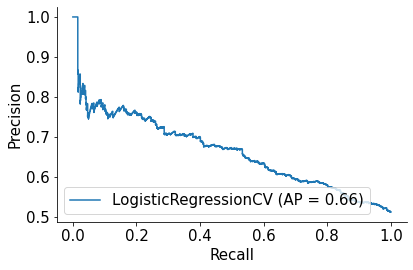

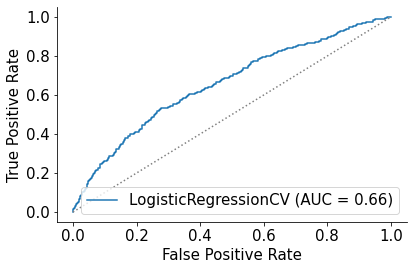

In [274]:
clasificator_analisis(clf_2,samples_pca_train,y_train )

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=8000, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=42, refit=True, scoring=None,
                     solver='saga', tol=0.0001, verbose=0) 
Accuracy:0.541953601953602

Confusion Matrix: 
 [[207  37]
 [170  38]]

Precision: 0.5066666666666667
Recall: 0.18269230769230768


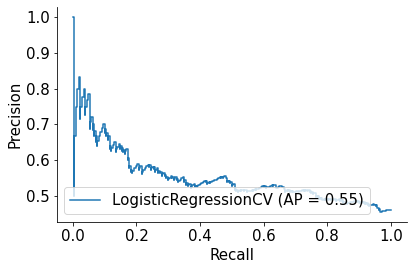

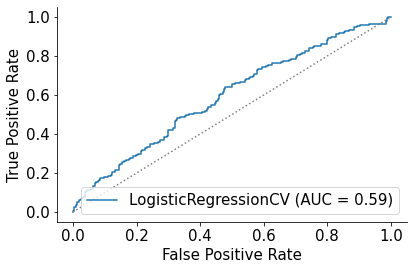

In [275]:
clasificator_analisis(clf_2,samples_pca_test,y_test )

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=8000, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=42, refit=True, scoring=None,
                     solver='saga', tol=0.0001, verbose=0) 
Accuracy:0.6086092715231788

Confusion Matrix: 
 [[526 211]
 [380 393]]

Precision: 0.6506622516556292
Recall: 0.5084087968952135


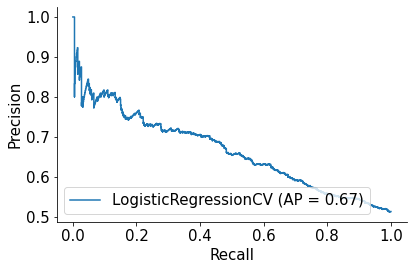

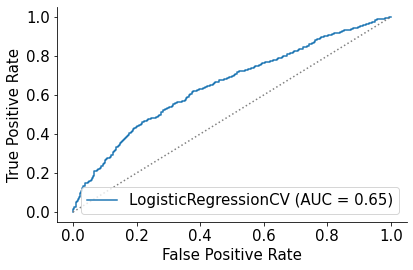

In [276]:
clasificator_analisis(clf_2_norm,samples_pca_train_norm,y_train )

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=8000, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=42, refit=True, scoring=None,
                     solver='saga', tol=0.0001, verbose=0) 
Accuracy:0.553040293040293

Confusion Matrix: 
 [[216  28]
 [174  34]]

Precision: 0.5483870967741935
Recall: 0.16346153846153846


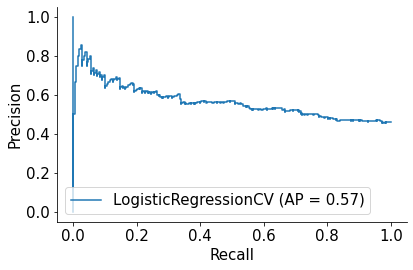

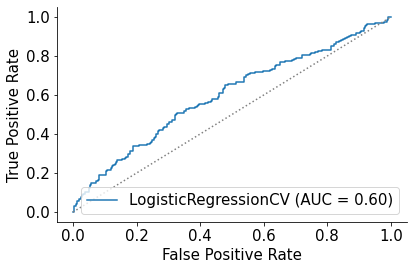

In [278]:
clasificator_analisis(clf_2_norm,samples_pca_test_norm,y_test )